In [ ]:
# -*- coding: utf-8 -*-
"""
PRONÓSTICO HORARIO DE DEMANDA SIN TEMPERATURA (MODELO HÍBRIDO) – CORREGIDO
===========================================================================

OBJETIVO
--------
Predecir demanda eléctrica horaria por subárea para los próximos ~90 días (3 meses) usando 5 años
de historia. **No** usamos temperatura; explotamos patrones de calendario y estacionalidad múltiple.

ENFOQUE (BASE TEÓRICA)
----------------------
(1) **Descomposición estacional y ARX lineal con regularización (Ridge)**:
    - Capturamos estacionalidades **diaria** (P=24) y **semanal** (P=168) con **términos de Fourier**:
        y_t ≈ β0 + Σ_k [ a_k sin(2πk t / P) + b_k cos(2πk t / P) ] + ...
      donde K (armónicos) controla el detalle. Fourier evita crear 24/168 dummies, es parsimonioso.
    - Añadimos **lags autoregresivos** (y_{t-1}, y_{t-24}, y_{t-168}) y **promedios móviles** (roll24, roll168)
      que capturan **inercia** y **tendencia suave**.
    - Incluimos **festivo** (0/1). Aunque es exógena de calendario, no es clima ni temperatura.
    - Ajustamos con **RidgeCV** (L2), que reduce el sobreajuste cuando hay muchas features (Fourier + lags).

(2) **Corrección de residuos con Machine Learning (Boosting)**:
    - El modelo lineal puede dejar **no linealidades** residuales (cambios de régimen día/semana, etc.).
    - Entrenamos un **HistGradientBoostingRegressor** para aprender los **residuos** en función de
      variables de calendario (hora y día de semana) y festivo.
    - Predicción final: ŷ_t = ŷ_t^(Ridge) + ŷ_t^(Residuos-Boosting).

(3) **Validación tipo operación (walk-forward)**:
    - En el **conjunto de prueba** (últimos 90 días) hacemos **pronóstico recursivo**:
      cada nueva hora usa lags construidos con **predicciones previas** (no con el valor real futuro).
    - Métricas: **MAPE** y **RMSE** por subárea y global. Incluimos un baseline naïve (y_{t-168}).

(4) **Pronóstico futuro (3 meses)**:
    - Usamos Fourier (determinístico) + calendario futuro (hora/dow) + festivos programados.
    - Como no hay temperatura, todo el futuro es determinista salvo la parte autoregresiva.

MEJORAS/BUGFIXES APLICADOS
--------------------------
- Se aseguran **dummies de calendario consistentes** (mismas columnas en train/test/futuro).
- Se **guardan y respetan** los **órdenes de columnas** usados al entrenar (Ridge y ML de residuos).
- Se evita el **duplicado de columnas** (Fourier/dummies/lag/roll) al recomputarlas en el recursivo.
- Se corrigen errores `InvalidIndexError`, `ValueError (feature names order)` y `UnboundLocalError`.

ADAPTACIÓN A DATOS REALES
-------------------------
- Reemplaza `build_panel()` por tu dataframe real con columnas:
  `timestamp, subarea, demand
- Mantén Fourier + lags + rollings + festivos; entrena y evalúa como aquí.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from pathlib import Path
import datetime as dt
import os

from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
# Información del proyecto y autenticación a BQ
project_id = "enersinc-tbsg-bq"
key_path = "C:\BigQuery\eramirez-tbsg.json"

# Cargar las credenciales del archivo JSON
credentials = service_account.Credentials.from_service_account_file(key_path)

# Crear el cliente de BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

In [4]:
FechaIni='2021-01-01'
FechaFin='2025-08-30'

In [5]:
# Consulta a la maestra de recursos
query = rf"""
select * from `enersinc-tbsg-bq`.tbsg.public_ddem
where fechaoperacion>='{FechaIni}' and fechaoperacion <='{FechaFin}'
"""

# Ejecutar la consulta
df_DemIni = client.query(query).to_dataframe()

c:\Users\eramirez\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [96]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import holidays
co_holidays = holidays.Colombia()

def typedays(row,tipo):

     if tipo=='WeekDay':
          return row['fecha'].weekday()
     
     elif tipo=='WeekMonth':
          return (row['fecha'].day - 1) // 7 + 1
     
     elif tipo=='DayTypeO':
          if row['fecha'] in co_holidays:
               return 0
          elif row['fecha'].weekday()==5:
               return 0
          elif row['fecha'].weekday()==6:
               return 0
          else:
               return 1
          
     elif tipo=='DayTypeS':

          if row['fecha'] in co_holidays:
               return 0
          elif row['fecha'].weekday()==5:
               return 1
          elif row['fecha'].weekday()==6:
               return 0
          else:
               return 0
          
     elif tipo=='DayTypeF':
          if row['fecha'] in co_holidays:
               return 1
          elif row['fecha'].weekday()==5:
               return 0
          elif row['fecha'].weekday()==6:
               return 1
          else:
               return 0

In [108]:
data=df_DemIni.copy()
data = data[~data['nombre'].isin(['Total','ECUADOR138','ECUADOR220','COROZO','CUATRIC','SubArea Venezuela_Corozo','SubArea Venezuela_Cuatricentenario',
                                  'SubArea Ecuador138', 'SubArea Ecuador230'])]
data['nombre'] = data['nombre'].apply(lambda x: x if x in ['ATLANTIC', 'BOLIVAR', 'GCM','CERROMAT', 'CORDOSUC', 'SubArea Atlantico','SubArea GCM',
                                                            'SubArea Cerromatoso','SubArea Bolivar','SubArea Cordoba_Sucre'] else 'Interior')
data['nombre'] = data['nombre'].replace({'ATLANTIC': 'SubArea Atlantico', 'BOLIVAR': 'SubArea Bolivar', 'GCM': 'SubArea GCM',
                                         'CERROMAT': 'SubArea Cerromatoso', 'CORDOSUC': 'SubArea Cordoba_Sucre'})

for i in range(1,25):
    data = data.rename(columns={f'hora{i}': i})

data = data.melt(id_vars=['fechaoperacion', 'nombre'], 
                       value_vars=[i for i in range(1, 25)], 
                       var_name='periodo', 
                       value_name='demand')

data=data.rename(columns={'nombre':'subarea','fechaoperacion':'fecha'})
data=data.groupby(['fecha','periodo','subarea'])[['demand']].sum().round(2).reset_index()
data['timestamp'] = pd.to_datetime(data['fecha']) + pd.to_timedelta(data['periodo']- 1,unit='h')

# Definir tipo de día
# data['dayo']=data.apply(lambda row: typedays(row,tipo='DayTypeO'),axis=1)
# data['days']=data.apply(lambda row: typedays(row,tipo='DayTypeS'),axis=1)
# data['dayf']=data.apply(lambda row: typedays(row,tipo='DayTypeF'),axis=1)
data=data.sort_values(by=['fecha','subarea','periodo'])

data=data[['timestamp','subarea','demand']]
data=data.reset_index(drop=True)
data

,timestamp,subarea,demand
0,2021-01-01 00:00:00,Interior,4415.94
1,2021-01-01 01:00:00,Interior,4204.97
2,2021-01-01 02:00:00,Interior,4037.55
3,2021-01-01 03:00:00,Interior,3911.95
4,2021-01-01 04:00:00,Interior,3837.69
...,...,...,...
245227,2025-08-30 19:00:00,SubArea GCM,910.05
245228,2025-08-30 20:00:00,SubArea GCM,925.22
245229,2025-08-30 21:00:00,SubArea GCM,880.62
245230,2025-08-30 22:00:00,SubArea GCM,884.77


#### Preparación y chequeos rápidos (gaps, orden, frecuencia)

In [61]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

# ==== 1.1 Cargar / normalizar columnas (ajusta 'data' a tu DF) ====
df = data.copy()  # <-- usa tu variable real
df.columns = [c.strip().lower().replace('#','').replace(' ','_') for c in df.columns]
# esperamos: timestamp | subarea | demand | (otros)

# ==== 1.2 Parseo, filtro subárea, orden y malla horaria ====
df['timestamp'] = pd.to_datetime(df['timestamp'])
sub = 'SubArea Atlantico'  # <- cambia si quieres otra subárea
sdf = df[df['subarea'] == sub].copy().sort_values('timestamp')

# Forzamos frecuencia horaria y detectamos huecos:
sdf = sdf.set_index('timestamp').sort_index()
full_idx = pd.date_range(sdf.index.min(), sdf.index.max(), freq='H')
missing = full_idx.difference(sdf.index)
print(f"Horas faltantes: {len(missing)}")

# Para graficar ACF sin NaN: o bien imputas (suave) o dropeas esas filas
# Sugerencia: para graficar ACF, elimina las horas faltantes:
sdf = sdf.reindex(full_idx)
sdf = sdf.rename_axis('timestamp').reset_index()
sdf = sdf.dropna(subset=['demand'])


Horas faltantes: 0


#### Mirada rápida de la serie (visuales contextuales)

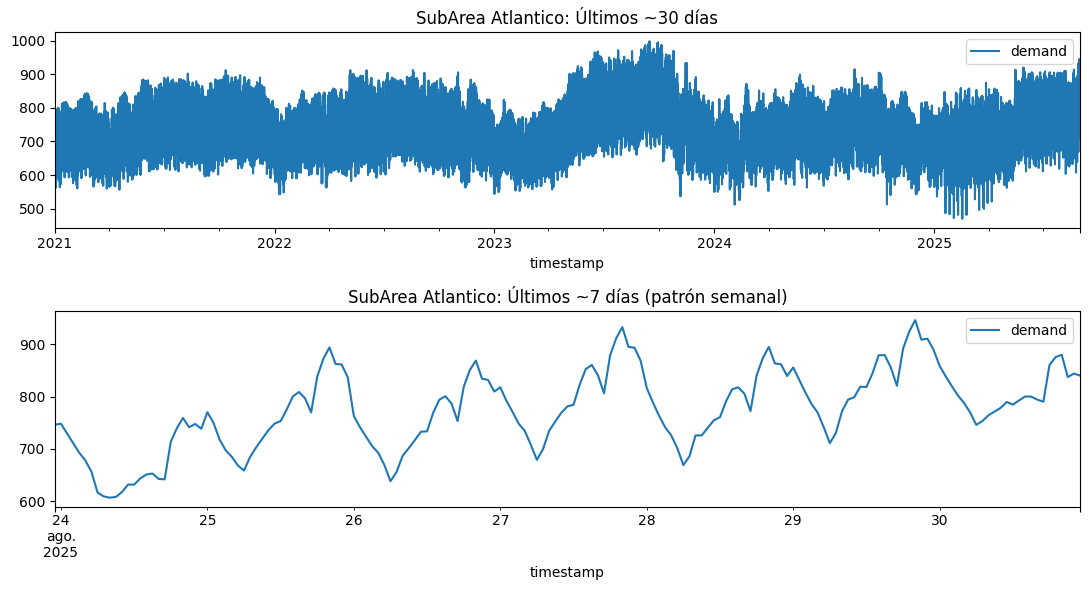

In [62]:
# Un mes típico + una semana para ver patrón
fig, axes = plt.subplots(2,1, figsize=(11,6), sharex=False)
last_month_start = sdf['timestamp'].max() - pd.Timedelta(days=30)
last_week_start  = sdf['timestamp'].max() - pd.Timedelta(days=7)

sdf.plot(x='timestamp', y='demand', ax=axes[0])
axes[0].set_title(f"{sub}: Últimos ~30 días")

sdf[sdf['timestamp']>=last_week_start].plot(x='timestamp', y='demand', ax=axes[1])
axes[1].set_title(f"{sub}: Últimos ~7 días (patrón semanal)")

plt.tight_layout(); plt.show()


#### ACF/PACF de la serie (para proponer lags mínimos)

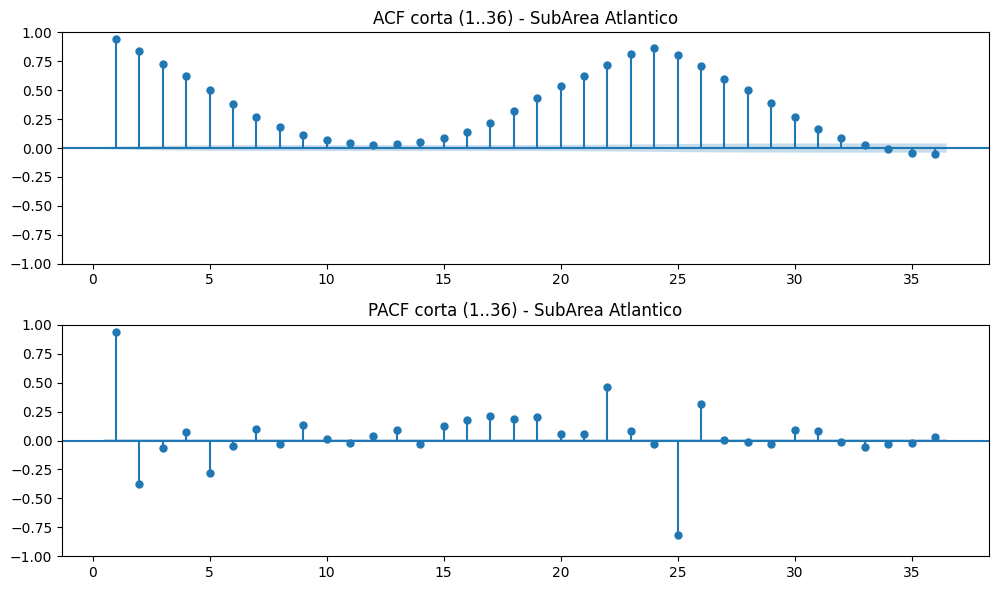

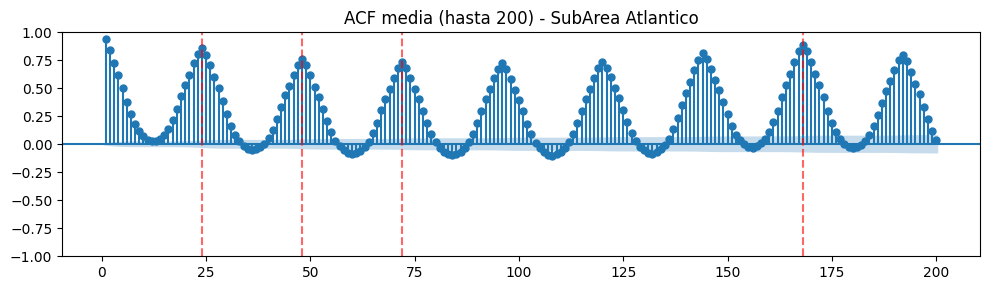

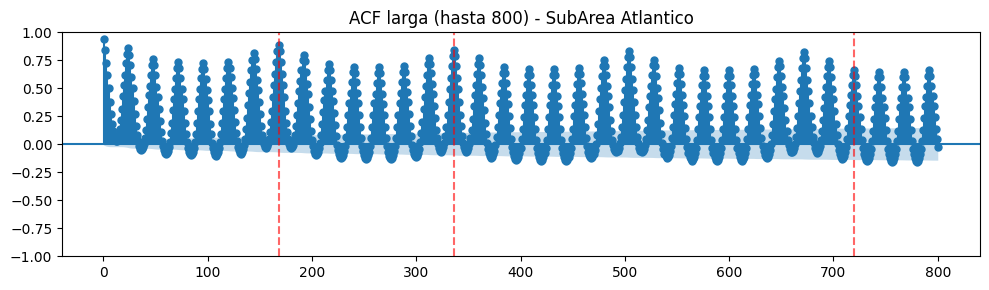

In [63]:
# Usamos TODO el histórico disponible
x = sdf['demand'].values
N = len(x)
max_lag = min(24*35, N-5)  # hasta ~5 semanas

# 3.1 ACF/PACF corto (memoria corta: 1..36 h)
fig, axes = plt.subplots(2,1, figsize=(10,6))
plot_acf(x, lags=36, zero=False, ax=axes[0])
axes[0].set_title(f"ACF corta (1..36) - {sub}")
plot_pacf(x, lags=36, zero=False, method='ywm', ax=axes[1])
axes[1].set_title(f"PACF corta (1..36) - {sub}")
plt.tight_layout(); plt.show()

# 3.2 ACF media (hasta ~200 h) para ver 24..192
fig, ax = plt.subplots(1,1, figsize=(10,3))
plot_acf(x, lags=200, zero=False, ax=ax)
ax.set_title(f"ACF media (hasta 200) - {sub}")
# líneas guía para 24/48/72 y 168
for L in [24,48,72,168]:
    ax.axvline(L, color='r', linestyle='--', alpha=0.6)
plt.tight_layout(); plt.show()

# 3.3 ACF larga (hasta ~800 h) para 336 y 720
fig, ax = plt.subplots(1,1, figsize=(10,3))
plot_acf(x, lags=min(800,N-5), zero=False, ax=ax)
ax.set_title(f"ACF larga (hasta 800) - {sub}")
for L in [168,336,720]:
    ax.axvline(L, color='r', linestyle='--', alpha=0.6)
plt.tight_layout(); plt.show()

###### Análisis

1) ACF corta (1..36)

Qué ves:

Autocorrelación muy alta en lags 1–6 (decay suave) ⇒ fuerte memoria corta.

Vuelve a subir y alcanza un pico grande alrededor de lag 24 ⇒ estacionalidad diaria.

Conclusión:

Los lags 1, 2, 3 son imprescindibles.

24 es estructural.

2) PACF corta (1..36)

Qué ves:

Un pico muy alto en lag 1 (y los siguientes ya mucho menores) ⇒ proceso con componente AR(1) dominante (memoria inmediata).

Señales en la vecindad de 24–25 (pico en 24 y/o caída en 25) ⇒ componente estacional alrededor de 24; el “diente” en 25 suele aparecer cuando hay AR estacional en 24 o mezcla AR/MA estacional.

Conclusión:

Lag 1 fijo.

Lag 24 fijo.

Vecinos 23/25 pueden ayudar si, tras modelar, quedaran residuos con estructura cerca de 24 (lo veremos con Ljung–Box/ACF de residuos).


3) ACF media (hasta 200)

Qué ves:

Ondas claramente periódicas con picos en 24, 48, 72… y un pico muy visible cerca de 168.

Esto es el patrón diario repetido y la semana (24×7).

Conclusión:

Lag 168 (semanal) también es estructural.

No hace falta meter 48/72 como lags si vas a usar Fourier diario con 
𝐾
daily
≥
3
K
daily
	​

≥3 (Fourier ya explica esos múltiplos); si no usases Fourier, podrían ser candidatos.

4) ACF larga (hasta 800)

Qué ves:

Picos notables en 168 y 336 (2 semanas).

Se aprecia señal cerca de 720 (≈ 30 días) —menor, pero visible.

Conclusión:

336 es buen candidato si después de modelar la semana aún quedan residuos correlacionados a escala bisemanal.

720 (≈ mensual) podría ayudar si tienes muchos meses de datos y ves mejora en backtest; si no aporta, se quita (es largo y colinear con otras estructuras).

#### 4) Aísla estacionalidades con diferencias estacionales y mira la ACF

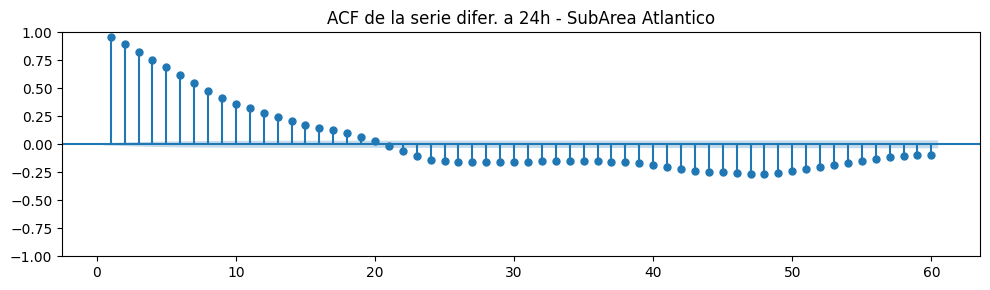

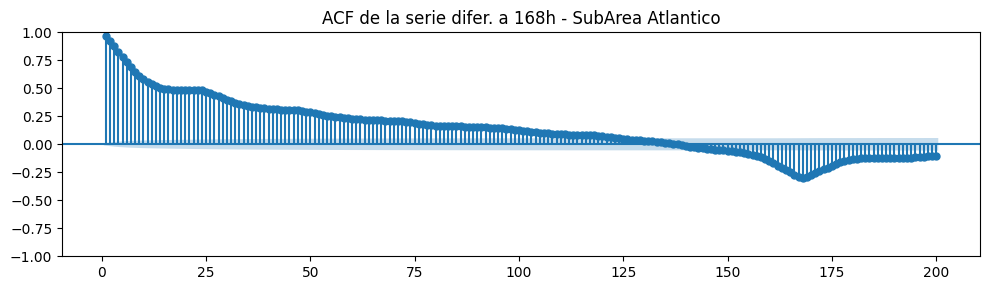

In [64]:
# 4.1 Diferencia diaria
xd24 = sdf['demand'] - sdf['demand'].shift(24)
xd24 = xd24.dropna().values

fig, ax = plt.subplots(1,1, figsize=(10,3))
plot_acf(xd24, lags=60, zero=False, ax=ax)
ax.set_title(f"ACF de la serie difer. a 24h - {sub}")
# mira si hay picos en 1..3 -> sugiere añadir 1–3 además de 24
plt.tight_layout(); plt.show()

# 4.2 Diferencia semanal
xd168 = sdf['demand'] - sdf['demand'].shift(168)
xd168 = xd168.dropna().values

fig, ax = plt.subplots(1,1, figsize=(10,3))
plot_acf(xd168, lags=200, zero=False, ax=ax)
ax.set_title(f"ACF de la serie difer. a 168h - {sub}")
# mira si hay picos en 1..3 o en ~24 -> sugiere vecinos ±1 de 168 o incluir 336
plt.tight_layout(); plt.show()


###### Análisis

5) ACF de la serie diferenciada a 24 h

Qué ves:

Tras quitar el patrón diario, siguen picos altos en 1–3 y decaimiento paulatino ⇒ hay memoria corta que no es solo “diaria”.

Cruces y ligera negatividad alrededor de 24–30 ⇒ típico de un MA estacional o desajuste fino del diario.

Conclusión:

Refuerza que 1–3 ayudan incluso quitando el diario.

Si más adelante los residuos aún muestran estructura alrededor de 24, entonces sí conviene añadir 23/25.


6) ACF de la serie diferenciada a 168 h

Qué ves:

Tras quitar la semana, queda memoria corta fuerte; además aparece una depresión (negativa) alrededor de ~168.

Esto sugiere vecinos semanales 167/169 y, si persiste, 336.

Conclusión:

167/168/169 son candidatos muy sólidos.

336 también entra en la lista de prueba.


7) ¿Qué hago con la “Sugerencia automática”?

[1, 2, 3, 23, 24, 25, 167, 168, 169, 335, 336, 337, 719, 720, 721]

Está totalmente alineada con lo que muestran tus gráficos:

Corta: 1–3

Diaria: 23–24–25

Semanal: 167–168–169

Bisemanal: 335–336–337

Mensual: 719–720–721

Pero: por parquedad/colinealidad no metas todo de una; prueba en bloques y quédate con lo que mejora backtest y limpia residuos.


8) Propuesta de conjuntos a probar (en este orden)

Base mínima (robusta):
L1 = [1, 24, 168]
→ Debe dar un salto grande respecto a no usar lags.

Añadir memoria corta:
L2 = [1, 2, 3, 24, 168]
→ Si L2 mejora MAPE/RMSE vs L1 y suben p-valores de Ljung–Box (24/168) > 0.05, te la quedas.

Añadir vecinos diarios y semanales:
L3 = [1, 2, 3, 23, 24, 25, 167, 168, 169]
→ Úsalo si aún ves estructura alrededor de 24 y 168 en residuos. Si no mejora o empeora RMSE (sobreajuste), vuelve a L2.

Añadir bisemanal:
L4 = L3 + [336] (primero 336, luego decide si hace falta 335/337).
→ Quédate con solo 336 si 335/337 no aportan.

Añadir mensual (si de verdad se ve en residual y mejora métricas):
L5 = L4 + [720] (los vecinos 719/721 solo si aportan y no te inflan varianza).

Regla: quédate con el set más simple que logre MAPE/RMSE bajos y Ljung–Box (24/168) > 0.05 en residuos.

9) Interacción con Fourier (muy importante)

Como tú usas Fourier para diario/semanal y además una capa ML de residuos, no necesitas muchos lags “múltiplo de 24”:

Con 
𝐾daily∈[3,5]Kdaily	​∈[3,5] y 𝐾weekly∈[2,3]Kweekly	​∈[2,3], normalmente basta con [1, 24, 168] (+ 336 si aplica).

Los vecinos ±1 (23/25, 167/169) solo se justifican si, después de sintonizar 
𝐾
K, los residuos siguen mostrando dientes justo ahí.

10) Qué esperar al validar (walk-forward + residuos)

Si pasas de L1→L2: MAPE y RMSE deben bajar; Ljung–Box 24/168 en residuos debe subir (p-valor > 0.05).

Si L3/L4/L5 no mejoran y/o bajan los p-valores ⇒ quítalos.

No olvides probar 1–2 configuraciones de 𝐾K (p. ej., 𝐾𝑑={3,4},𝑤={2,3}Kd	​={3,4},Kw	​={2,3}) con el mejor set de lags; a veces un 𝐾K un poco mayor elimina la necesidad de vecinos ±1


Conclusión corta (Atlántico)

Fijos: 1, 24, 168.

Muy probables: 2, 3 y 336.

Condicionales (si residuos lo piden): 23/25 y 167/169.

Mensual (720): sólo si ves mejora real en backtest.

#### 5) Construye tu lista candidata de lags (regla clara)

In [65]:
def suggest_from_acf(x, max_lag=800, add_neighbors=True):
    N = len(x)
    nlags = min(max_lag, N-5)
    vals = acf(x, nlags=nlags, fft=True)
    thr = 1.96/np.sqrt(N)

    base = {1,24,168}
    structural = [24,168,336,720]
    cand = set(base)

    for L in structural:
        if L <= nlags and abs(vals[L]) > thr:
            cand.add(L)
            if add_neighbors:
                for v in (L-1, L+1):
                    if 1 <= v <= nlags and abs(vals[v]) > thr*0.9:
                        cand.add(v)

    # memoria corta
    for L in (2,3):
        if L <= nlags and abs(vals[L]) > thr:
            cand.add(L)
    return sorted(cand)

auto_lags = suggest_from_acf(sdf['demand'].values)
print("Sugerencia automática (verifícala con las gráficas):", auto_lags)


Sugerencia automática (verifícala con las gráficas): [1, 2, 3, 23, 24, 25, 167, 168, 169, 335, 336, 337, 719, 720, 721]


#### Funciones para ejecutar el modelo

#### Prueba de los Lags

##### Fucniones para el modelo

In [109]:

# =========================
# 0) PARÁMETROS GENERALES
# =========================
RANDOM_SEED   = 42
np.random.seed(RANDOM_SEED)

N_SUBAREAS    = 6
START_DATE    = "2020-01-01 00:00:00"
END_DATE      = "2024-12-31 23:00:00"   # ~5 años de historia
TEST_DAYS     = 90                      # evaluación operativa (walk-forward)
FORECAST_DAYS = 90                      # pronóstico futuro ≈ 3 meses

# Estacionalidades
DAILY_PERIOD  = 24                      # ciclo diario
WEEKLY_PERIOD = 24 * 7                  # ciclo semanal
K_DAILY       = 3                       # nº armónicos diarios
K_WEEKLY      = 2                       # nº armónicos semanales

# Lags ARX
LAGS = [1, 24, 168]                     # 1h, 1 día, 1 semana

In [117]:
# === Imports necesarios para entrenar y pronosticar ===
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import HistGradientBoostingRegressor

# ----------------------------------------------------
# Funciones faltantes para que el runner corra directo
# ----------------------------------------------------
import numpy as np
import pandas as pd

def add_calendar_dummies(df: pd.DataFrame, holiday_index: pd.DatetimeIndex | None = None) -> pd.DataFrame:
    """
    Dummies consistentes (sin drop_first) con columnas fijas:
    - h_0..h_23
    - dow_0..dow_6
    - day_ordinario, day_sabado, day_festivo   (festivo ≡ domingo o fecha en holiday_index)

    Parámetros
    ----------
    df : DataFrame con al menos 'timestamp' (datetime)
    holiday_index : DatetimeIndex opcional con fechas festivas (normalizadas a 00:00)

    Devuelve
    --------
    DataFrame con dummies enteras (int)
    """
    # Hora y día de semana (one-hot)
    hours = pd.Categorical(df["timestamp"].dt.hour, categories=range(24))
    dows  = pd.Categorical(df["timestamp"].dt.dayofweek, categories=range(7))
    H  = pd.get_dummies(hours, prefix="h",  drop_first=False)
    DW = pd.get_dummies(dows,  prefix="dow", drop_first=False)

    # --- TIPO DE DÍA: ordinario / sábado / festivo ---
    dow = df["timestamp"].dt.dayofweek  # 0=Lun ... 6=Dom

    # festivos externos (si se proveen)
    if holiday_index is not None:
        # normaliza timestamps a fecha para comparar con holiday_index (que debe estar normalizado)
        is_hol_ext = df["timestamp"].dt.normalize().isin(holiday_index)
    else:
        is_hol_ext = pd.Series(False, index=df.index)

    # festivo ≡ domingo o fecha festiva externa
    is_festivo = is_hol_ext | (dow == 6)
    is_sabado  = (dow == 5) & (~is_festivo)

    day_type = np.select(
        [is_festivo, is_sabado],
        ["festivo",  "sabado"],
        default="ordinario"
    )

    cat = pd.Categorical(day_type, categories=["ordinario","sabado","festivo"])
    DAY = pd.get_dummies(cat, prefix="day", drop_first=False)

    out = pd.concat([H, DW, DAY], axis=1).astype(int)
    out.index = df.index
    return out

def prepare_xy(df):
    """
    X = features para la capa Ridge (usa la lista global ridge_features)
    y = demanda; filtra filas inválidas por NaN (lags/rollings).
    """
    X = df[ridge_features].copy()
    y = df["demand"].copy()
    valid = ~X.isna().any(axis=1) & y.notna()
    return X[valid], y[valid], valid

def fit_models_for_subarea(df_sub):
    """
    Entrena:
      (A) RidgeCV (Fourier + lags/rollings ).
      (B) Boosting sobre RESIDUOS, con dummies calendario.
    Devuelve meta con el orden exacto de columnas que vio cada modelo.
    Requiere: test_start, ridge_features definidos por tu runner.
    """
    local = df_sub.copy().reset_index(drop=True)

    # Split temporal
    train_mask = local["timestamp"] < test_start

    # Capa A: Ridge
    X_train, y_train, vtrain = prepare_xy(local[train_mask])
    ridge = RidgeCV(alphas=np.logspace(-4, 4, 17), fit_intercept=True)
    ridge.fit(X_train, y_train)

    # Residuos de entrenamiento
    resid_train = y_train - ridge.predict(X_train)

    # Capa B: ML (residuos) con dummies calendario 
    train_valid_df = local[train_mask].loc[vtrain].copy()
    cal_block = add_calendar_dummies(train_valid_df)
    X_train_ml = cal_block.reset_index(drop=True)
    
    ml = HistGradientBoostingRegressor(
    max_depth=8, max_iter=400, learning_rate=0.05,
    min_samples_leaf=20, random_state=42)
    ml.fit(X_train_ml, resid_train)

    # guardamos orden de columnas para reindexar en predicción
    meta = {
        "ridge_features_order": list(X_train.columns),
        "ml_features_order":    list(X_train_ml.columns)
    }
    return ridge, ml, meta

def recursive_forecast(df_sub, ridge, ml, horizon_hours, start_time, meta):
    """
    Pronóstico recursivo:
      - Usa 'yhat' para construir lags (no valores reales futuros).
      - Reconstruye Fourier y dummies en hist+futuro.
      - Reindexa EXACTAMENTE con los órdenes guardados en meta.
    Requiere: K_DAILY, K_WEEKLY, LAGS definidos (tu runner los define en rebuild_*).
    """
    DAILY_PERIOD  = 24
    WEEKLY_PERIOD = 168

    hist = df_sub[df_sub["timestamp"] <= start_time].copy().reset_index(drop=True)
    subname = hist["subarea"].iloc[0]

    # Calendario futuro simple (ajústalo si tienes festivos reales)
    fut_idx = pd.date_range(start_time + pd.Timedelta(hours=1), periods=horizon_hours, freq="H")
    future  = pd.DataFrame({"timestamp": fut_idx, "subarea": subname})

    # Fourier consistente en hist+futuro con (K_DAILY, K_WEEKLY)
    all_idx = pd.DatetimeIndex(pd.concat([hist["timestamp"], future["timestamp"]]))
    t = np.arange(len(all_idx))
    # diarios
    ft_d = {}
    for k in range(1, int(K_DAILY)+1):
        ft_d[f"sin_{DAILY_PERIOD}_{k}"] = np.sin(2*np.pi*k*t/DAILY_PERIOD)
        ft_d[f"cos_{DAILY_PERIOD}_{k}"] = np.cos(2*np.pi*k*t/DAILY_PERIOD)
    # semanales
    ft_w = {}
    for k in range(1, int(K_WEEKLY)+1):
        ft_w[f"sin_{WEEKLY_PERIOD}_{k}"] = np.sin(2*np.pi*k*t/WEEKLY_PERIOD)
        ft_w[f"cos_{WEEKLY_PERIOD}_{k}"] = np.cos(2*np.pi*k*t/WEEKLY_PERIOD)

    ft_all = pd.DataFrame({**ft_d, **ft_w}, index=all_idx).reset_index().rename(columns={"index":"timestamp"})
    hist   = hist.merge(ft_all,   on="timestamp", how="left")
    future = future.merge(ft_all, on="timestamp", how="left")

    # Dummies calendario
    hist   = pd.concat([hist,   add_calendar_dummies(hist)],  axis=1)
    future = pd.concat([future, add_calendar_dummies(future)], axis=1)

    # yhat inicial = demanda histórica
    hist["yhat"] = hist["demand"]

    def update_lags_and_rolls(df):
        for L in LAGS:
            df[f"lag_{L}"] = df["yhat"].shift(L)
        df["roll24"]  = df["yhat"].rolling(24,  min_periods=1).mean()
        df["roll168"] = df["yhat"].rolling(168, min_periods=1).mean()
        return df

    hist = update_lags_and_rolls(hist)

    preds = []
    ridge_cols = meta["ridge_features_order"]
    ml_cols    = meta["ml_features_order"]

    for tstamp in future["timestamp"]:
        row_fut = future[future["timestamp"] == tstamp].copy()
        tmp = pd.concat([hist, row_fut], ignore_index=True, sort=False)
        tmp = update_lags_and_rolls(tmp)

        # Capa A: Ridge
        Xr = tmp.iloc[[-1]].reindex(columns=ridge_cols)
        Xr = Xr.ffill().bfill().fillna(0)  # forward fill -> backward fill -> 0 de respaldo
        yhat_A = ridge.predict(Xr)[0]

        # Capa B: ML (residuos)
        Xm = tmp.iloc[[-1]].reindex(columns=ml_cols).fillna(0)
        yhat_res = ml.predict(Xm)[0]

        yhat = yhat_A + yhat_res

        # Realimentación
        new_row = tmp.iloc[[-1]].copy()
        new_row["yhat"]   = yhat
        new_row["demand"] = np.nan
        hist = pd.concat([hist, new_row], ignore_index=True, sort=False)

        preds.append({"timestamp": tstamp, "subarea": subname, "yhat": yhat})

    return pd.DataFrame(preds)

def walkforward_test(df_sub, ridge, ml, meta):
    """
    Valida en el tramo de test (últimos ~90 días por defecto).
    Usa pronóstico recursivo y devuelve y_true, y_pred alineados.
    Requiere: test_start definido por tu runner.
    """
    local = df_sub.copy().reset_index(drop=True)

    t0 = local.loc[local["timestamp"] >= test_start, "timestamp"].min()
    t1 = local["timestamp"].max()
    horizon_hours = int((t1 - t0) / pd.Timedelta(hours=1)) + 1

    preds = recursive_forecast(local, ridge, ml, horizon_hours,
                               start_time=t0 - pd.Timedelta(hours=1),
                               meta=meta)

    truth = local[(local["timestamp"] >= t0) & (local["timestamp"] <= t1)][
        ["timestamp", "demand"]
    ].reset_index(drop=True)

    out = preds.merge(truth, on="timestamp", how="left")
    return out["demand"].values, out["yhat"].values


In [115]:
def compute_basic_metrics(y_true, y_pred):
    mape  = mean_absolute_percentage_error(y_true, y_pred)*100
    smape = 100*np.mean(2*np.abs(y_pred-y_true)/(np.abs(y_pred)+np.abs(y_true)+1e-9))
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
    mae   = mean_absolute_error(y_true, y_pred)
    return mape, smape, rmse, mae

def eval_model(df_sub):
    """Entrena tu pipeline y evalúa en el hold-out (usa tus funciones)."""
    ridge, ml, meta = fit_models_for_subarea(df_sub)
    y_true, y_pred  = walkforward_test(df_sub, ridge, ml, meta)
    mape, smape, rmse, mae = compute_basic_metrics(y_true, y_pred)
    resid = y_true - y_pred
    lb24  = acorr_ljungbox(resid, lags=[24],  return_df=True)["lb_pvalue"].iloc[0]
    lb168 = acorr_ljungbox(resid, lags=[168], return_df=True)["lb_pvalue"].iloc[0]
    return mape, rmse, lb24, lb168

def rebuild_fourier(data_in, Kd, Kw):
    """Quita Fourier previo, recalcula con (Kd,Kw) y actualiza ridge_features."""
    data2 = data_in.drop(columns=[c for c in data_in.columns if c.startswith(("sin_","cos_"))], errors="ignore").copy()
    unique_ts = data2["timestamp"].drop_duplicates()

    def fourier_terms(ts, period, K):
        t = np.arange(len(ts)); out={}
        for k in range(1, K+1):
            out[f"sin_{period}_{k}"] = np.sin(2*np.pi*k*t/period)
            out[f"cos_{period}_{k}"] = np.cos(2*np.pi*k*t/period)
        return pd.DataFrame(out, index=ts)

    DAILY_PERIOD  = 24
    WEEKLY_PERIOD = 168
    ft_d = fourier_terms(unique_ts, DAILY_PERIOD,  Kd)
    ft_w = fourier_terms(unique_ts, WEEKLY_PERIOD, Kw)
    ft   = pd.concat([ft_d, ft_w], axis=1).reset_index().rename(columns={"index":"timestamp"})
    data2 = data2.merge(ft, on="timestamp", how="left")

    # Actualiza features del Ridge (usa tus globals)
    global K_DAILY, K_WEEKLY, ridge_features
    K_DAILY, K_WEEKLY = Kd, Kw
    ridge_features = (
        [ "roll24", "roll168"] +
        [c for c in data2.columns if c.startswith(("sin_","cos_"))] +
        [c for c in data2.columns if c.startswith("lag_")]
    )
    return data2

def rebuild_lags(data_in, lag_list):
    data2 = data_in.drop(columns=[c for c in data_in.columns if c.startswith("lag_") or c in ("roll24","roll168")],
                         errors="ignore").copy()
    def add_dyn(g):
        for L in lag_list:
            g[f"lag_{L}"] = g["demand"].shift(L)
        g["roll24"]  = g["demand"].rolling(24,  min_periods=1).mean()
        g["roll168"] = g["demand"].rolling(168, min_periods=1).mean()
        return g
    return data2.groupby("subarea", group_keys=False).apply(add_dyn)

def set_lag_list_and_rebuild(data_in, lag_list):
    """Actualiza lista global LAGS y ridge_features, y regresa data con lags calculados."""
    global LAGS, ridge_features
    LAGS = list(lag_list)
    d2 = rebuild_lags(data_in, LAGS)
    ridge_features = (
        ["roll24","roll168"] +
        [c for c in d2.columns if c.startswith(("sin_","cos_"))] +
        [f"lag_{L}" for L in LAGS]
    )
    return d2


In [118]:
# ===========================================
# Runner rápido: L1..L4 con impresión legible
# ===========================================

# ---------- 0) Seguridad / normalización ----------
df = data.copy()
df.columns = [c.strip().lower().replace('#','').replace(' ','_') for c in df.columns]
df['timestamp'] = pd.to_datetime(df['timestamp'])

NumDiasTest=30

last_ts = df['timestamp'].max()
test_start = last_ts - pd.Timedelta(days=NumDiasTest) + pd.Timedelta(hours=1)

global test_start

# ---------- 2) Define sets de lags a probar ----------
L4 = [1, 2, 3, 23, 24, 25, 167, 168, 169, 336]


# ---------- 3) Fija Fourier sensato (ajústalo si ya sintonizaste K) ----------
Kd, Kw = 3, 2   # K_daily=3, K_weekly=2 suele ser un buen punto de partida
dK = rebuild_fourier(df, Kd, Kw)

# ---------- 4) Loop principal (guardar en DataFrames) ----------
s = 'SubArea Atlantico'

d_ls = set_lag_list_and_rebuild(dK, L4)

mape, rmse, lb24, lb168 = eval_model(d_ls[d_ls["subarea"]== s].copy())

In [123]:
lb168

0.0